<a href="https://colab.research.google.com/github/CristianMorasso/statistical_project/blob/master/Copia_di_statiscal_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Learning Project: ALFA Dataset Anaysis


## Setup:

### Download the dataset and parse the files

In [ ]:
# Download the dataset from our git repository hosted on Github
!pip install icecream scikit-learn polars numpy imbalanced-learn sktime
!rm -rf statiscal_project
!git clone https://github.com/CristianMorasso/statistical_project.git

LEN_DATASET = 45

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 8.2 MB/s eta 0:00:00
Cloning into 'statistical_project'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 139 (delta 28), reused 3 (delta 1), pack-reused 70
Receiving objects: 100% (139/139), 92.30 MiB | 6.44 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Updating files: 100% (67/67), done.


In [ ]:
# Read the data from the csv files
import numpy as np
import pandas  as pd
import os
from random import shuffle

dataset_dir = "statistical_project/data"
dfs = [] # dataframe list

classToString= {0:"no_failure", 1:"elevator", 2:"engine", 3:"rudder",4:"ailerons"}

stringToClass = {}
for key, value in classToString.items():
  stringToClass[value] = key

series_counter = 0

for _, cl  in enumerate(os.listdir(dataset_dir)):
  path1 = os.path.join(dataset_dir, cl)

  # Get rid of files or bad dirs
  if not os.path.isdir(path1) or cl == "features":
    print(f"{cl} is not a dir or not useful!")
    continue

  for f in  os.listdir(path1):
    pathf = os.path.join(path1, f)
    df = pd.read_csv(pathf)

    # Fix the label field
    try:
      df["field.data"] = df["field.data"].apply(func=lambda x: stringToClass[cl] if int(x)>0 else 0)
      df = df.rename(columns={"field.data": "Y"})
    except:
      print(f"Error for {cl}")
      df["Y"]  = pd.Series([ 0 for _ in range(df.shape[0])])

    # Drop the time column!
    df = df.drop("%time", axis=1)

    # Save it
    dfs.append(df)
    series_counter+=1

print(f"\nNumber of Time Series: {len(dfs)}")
assert len(dfs) == LEN_DATASET # We know the exact number from the repo

# Shuffle the array of dataframes for so that classes are not contiguous
shuffle(dfs)

features is not a dir or not useful!
README.md is not a dir or not useful!
__init__.py is not a dir or not useful!
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure

Number of Time Series: 45


### Remove unusable features and Inpute missing values

In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np

# Remove useless features and inpute missing values
#
# finally use the mask on every timeseries of the OG dataframes list

# Remove all the features that are not shared by all Time Series
#
# Only use the variables that can be found in all the dataframes
features = []
# Get the biggest set:
# (We are considering that that the bigger set is just a superset and has all the other base features)
for df in dfs:
   features = max(features, df.columns.values, key=lambda x: len(x))
# Then get the set intersection of all of the features sets
features = set(features)
for df in dfs:
  features = features.intersection(set(df.columns.values))

# Apply the feature mask
print(len(features))
dfs = list(map(lambda x: x[list(features)] , dfs))

# Concat all the time series in as single dataframe for later :)
concatted_dfs = pd.concat(dfs)
concatted_y = concatted_dfs["Y"]
concatted_dfs = concatted_dfs.drop("Y", axis=1)

26


In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np

# Inpute the missing values first
dfs = list(map(lambda x: SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(x) , dfs))

### Split the dataset into windows

In [ ]:
from sktime.split import SlidingWindowSplitter

splitted_ndarrays, window_length, step_length = [], 10, 10
splitter = SlidingWindowSplitter(window_length=window_length, step_length=step_length)
splitted_ndarrays = [ list(map(lambda x: x[0], splitter.split_series(df))) for df in dfs] # We are ignoring the forecasting horizon

print(f"Length of windowed dataset: {len(splitted_ndarrays)}")
assert len(splitted_ndarrays) == LEN_DATASET

Length of windowed dataset: 45


In [ ]:
# Split into windows
_splitted_ndarrays = []
_splitted_ys = []
features = list(features)
y_index = features.index("Y") # Index of the Y column
features.pop(y_index)
#features = ["flight", "step", *features]

i = 0 # Number of windows

for sa in splitted_ndarrays:
  for a in sa:

    # Retrieve the label and save it separately
    _splitted_ys.append(np.max(a[:,y_index]))
    # And then delete it
    a = np.delete(a, y_index, axis=1)

    # np.concatenate([flight, step, a], axis=1)
    _splitted_ndarrays.append(a)
    i+=1 # Increase window counter

assert len(_splitted_ys) == len(_splitted_ndarrays)
print("n_windows",len(_splitted_ndarrays))

n_windows 9342


### Split in Train and set:

In [ ]:
import math
from random import shuffle
from collections import Counter

split = 0.8
zipped = list(zip(_splitted_ndarrays, _splitted_ys))

X_train, X_test = [], []
y_train, y_test = [], []
for val in classToString.keys():
  class_specific = list(filter(lambda x: x[1]==val, zipped))
  train_size = int(len(class_specific)*split)
  shuffle(class_specific)
  # Train Params for the class
  X_train += list(map(lambda x: x[0], class_specific[:train_size]))
  y_train += list(map(lambda x: x[1], class_specific[:train_size]))

  # Test Params for the class
  X_test  += list(map(lambda x: x[0], class_specific[train_size:]))
  y_test  += list(map(lambda x: x[1], class_specific[train_size:]))


print(f"Class distribution Train: {Counter(y_train)}")
print(f"Class distribution Test: {Counter(y_test)}")
# Switch to np.ndarray
y_train, y_test = np.array(y_train), np.array(y_test)


Class distribution Train: Counter({0.0: 6237, 2.0: 575, 4.0: 558, 3.0: 65, 1.0: 36})
Class distribution Test: Counter({0.0: 1560, 2.0: 144, 4.0: 140, 3.0: 17, 1.0: 10})


### Multi-Indexed Pandas Dataframe (sktime Panel)

In [ ]:
feature_mask = [*features]

def toMultiIndexed(windows, feature_mask, start=0):
  _dfs = []
  for i, npVals in enumerate(windows):
    d = pd.DataFrame(npVals,columns=feature_mask)

    # The two columns for the multi-indexed Dataframe
    d.insert(0, "flight", [i + start for _ in range(int(npVals.shape[0]))], True, )
    d.insert(1, "step", pd.RangeIndex(int(npVals.shape[0])), True)
    d = d.set_index(["flight", "step"])

    _dfs.append(d)

  _dfs = pd.concat(_dfs)

  return _dfs

X_train, X_test = toMultiIndexed(X_train, features), toMultiIndexed(X_test, features)
feature_mask = ["flight", "step", *features]

In [ ]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
X_train.head(20)

X_train: (74710, 25)
X_test: (18710, 25)
y_train: (7471,)
y_test: (1871,)


delta_roll_airspeed  delta_pitch  field.xtrack_error  \
flight step                                                         
0      0               -1.762379     6.905077          -15.117099   
       1               -1.762379     6.895077          -15.117099   
       2               -1.607105     6.645077          -14.382395   
       3               -1.607105     7.067142          -14.382395   
       4               -1.505129     6.877142          -13.725614   
       5               -1.505129     6.827143          -13.725614   
       6               -1.394909     6.677142          -13.113360   
       7               -1.394909     6.637142          -13.113360   
       8               -1.354202     6.437142          -12.567898   
       9               -1.354202     6.437142          -12.567898   
1      0               16.000000     0.365537          -83.023659   
       1               16.000000     0.475537          -81.740303   
       2               16.000000     0.475537          -81.740303   
       3               16.000000     0.575537          -80.428970   
       4               16.000000     0.575537          -80.428970   
       5               16.000000     0.859541          -79.138039   
       6               16.000000     0.859541          -79.138039   
       7               16.000000     0.859541          -79.138039   
       8               16.000000     0.999541          -77.814194   
       9               16.000000     1.129541          -76.523262   

             field.angular_velocity.x  field.aspd_error    delta_x  \
flight step                                                          
0      0                    -0.408304       -176.237869  -8.107393   
       1                    -0.408304       -176.237869  -7.749399   
       2                    -0.298749       -160.710526  -7.371600   
       3                    -0.298749       -160.710526  -7.112073   
       4                    -0.298749       -150.512878  -6.859674   
       5                    -0.298749       -150.512878  -6.382339   
       6                    -0.298749       -139.490891  -6.255699   
       7                    -0.298749       -139.490891  -5.784150   
       8                    -0.298749       -135.420227  -5.667558   
       9                    -0.298749       -135.420227  -5.667558   
1      0                    -0.020084        -64.814186   9.970822   
       1                    -0.020084        -64.814186   9.977947   
       2                    -0.020084        -64.814186   9.977947   
       3                    -0.020084        -70.034981   9.981352   
       4                    -0.020084        -70.034981   9.981352   
       5                    -0.065430        -70.034981   9.988646   
       6                    -0.065430        -70.034981   9.992212   
       7                    -0.065430        -70.034981   9.992212   
       8                    -0.065430        -74.586487  10.007496   
       9                    -0.065430        -74.586487  10.013271   

             field.linear_acceleration.y  field.twist.angular.y  \
flight step                                                       
0      0                        1.049312              -0.264721   
       1                        1.049312              -0.264721   
       2                        0.764919              -0.264721   
       3                        0.764919              -0.264721   
       4                        0.764919              -0.264721   
       5                        0.764919              -0.329213   
       6                        0.764919              -0.329213   
       7                        0.764919              -0.329213   
       8                        0.764919              -0.329213   
       9                        0.764919              -0.329213   
1      0                        0.519752               0.005906   
       1                        0.519752               0.005906   
       2       

### Feature Selection

In [ ]:
# Parameters for Feature selection
concatted_dfs = X_train.copy()
concatted_dfs.reset_index(drop=True, inplace=True)

concatted_y = []
for val in y_train.tolist():
  concatted_y += [val for _ in range(window_length)]
concatted_y = np.array(concatted_y)

concatted_dfs.head()
assert concatted_dfs.shape[0] == concatted_y.shape[0], "Not the same number of labels"

##### With SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest
import numpy as np

# Get the best 20 features of the dataset
columns_ = concatted_dfs.columns.values
feature_mask= SelectKBest(k=20).fit(concatted_dfs, concatted_y).get_feature_names_out(columns_)

print("Feature Mask:")
print(feature_mask)
print(f"Length of Feature Mask: {len(feature_mask)}")

Feature Mask:
['delta_roll_airspeed' 'delta_pitch' 'field.xtrack_error'
 'field.aspd_error' 'field.linear_acceleration.y' 'delta_z'
 'field.linear_acceleration.x' 'field.twist.linear.x'
 'field.twist.linear.y' 'delta_yaw' 'field.orientation.y' 'delta_y'
 'field.orientation.x' 'field.angular_velocity.z' 'field.alt_error'
 'field.linear_acceleration.z' 'field.orientation.z'
 'field.twist.angular.z' 'field.twist.linear.z' 'delta_roll']
Length of Feature Mask: 20


#### With randomForest scores:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importances(model):
    fig_scale = 0.9
    n_features = len(concatted_dfs.columns) # take the features names from the Concatted DataFrame
    plt.figure(figsize=(7*fig_scale,5.4*fig_scale))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), concatted_dfs.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


##### With Error Columns:

In [ ]:
# WITH ERROR COLUMNS:
#
concatted_ndarray = concatted_dfs.to_numpy()
rf = RandomForestClassifier()
rf.fit(concatted_ndarray, concatted_y)
# Plot the feature importances
plot_feature_importances(rf)

# Select the n best features
n = 20 # Removing 7 (the ones that are clearly not performing
couples = list(zip(concatted_dfs.columns, rf.feature_importances_))
couples.sort(key=lambda x: x[1])
accepted_features = list(map(lambda x: x[0], feature_mask[:n]))
feature_mask = ["flight", "step", *[c[0] for c in couples if (c[0] in accepted_features)] ]

###### Without error columns:

In [ ]:
# WITHOUT ERROR COLUMNS:
#
concatted_dfs = concatted_dfs.drop(["field.alt_error", "field.xtrack_error", "field.aspd_error"], axis=1)
concatted_ndarray = concatted_dfs.to_numpy()
rf = RandomForestClassifier()
rf.fit(concatted_ndarray, concatted_y)
# Plot the feature importances
plot_feature_importances(rf)

# Select the n best features
n = 20 # Removing 7 (the ones that are clearly not performing
couples = list(zip(concatted_dfs.columns, rf.feature_importances_))
couples.sort(key=lambda x: x[1])
accepted_features = list(map(lambda x: x[0], feature_mask[:n]))
feature_mask = ["flight", "step", [c[0] for c in couples if (c[0] in accepted_features )]* ]

### Rebalancing:


#### K neighbours implementation for k-neighbours and no predict

In [ ]:
import numpy as np

class DTW_KNN():
    def __init__(self, k=3):
        self.k = k
        self.data = None

    @staticmethod
    def dtw_distance(ts1: np.ndarray, ts2: np.ndarray):
      n, m = ts1.shape[0], ts2.shape[0]
      # Add one dimension up and on the left so we don't go out of bounds :)
      dtw_matrix = np.zeros((n+1, m+1))

      for i, row1 in enumerate(ts1, 1):
          for j, row2 in enumerate(ts2, 1):
              # L2 Norm == euclidian distance
              cost = np.linalg.norm(row1 - row2)

              # Get the previous smallest cost
              smaller = min(dtw_matrix[i-1, j],    # cell on the left
                            dtw_matrix[i, j-1],    # cell up
                            dtw_matrix[i-1, j-1])  # cell with the same idnex (diagonal, the best one for the shortest path)

              # And just keep the memory of the smallest path up to this position
              dtw_matrix[i, j] = cost + smaller

      return dtw_matrix[n, m]

    def fit(self, X: pd.DataFrame):
        self.data = X
        self.indexes = np.unique(X.index.get_level_values('flight').to_numpy()).tolist()

    def kneighbours(self, x: pd.DataFrame):
        index_distances= []
        x_index = x.index.get_level_values('flight')[0]

        x.reset_index(drop=True, inplace=True)
        x = x.to_numpy()

        # Let's just bruteforce this :)
        for index in self.indexes:
            # We can't keep x as a viable neighbour!
            if x_index == index: continue
            point = self.data.loc[index]
            point.reset_index(drop=True, inplace=True)

            distance = self.dtw_distance(x, point.to_numpy())
            index_distances.append(tuple([distance, index]))

        return list(map(lambda x: x[1],sorted(index_distances, key=lambda x: x[0])[:self.k]))


#### DTW_SMOTE

In [ ]:
import random
import numpy as np

class DTW_SMOTE():
  """
  Inputs:
    T = multi-indexed Pandas Dataframe
    N = Amount of SMOTE N %;
    k = Number of nearest neighbors k;
  """

  def __init__(self, T, N, k, start=0):
    # The amount of SMOTE is assumed to be in integral multiples of 100.
    self.N = int(N/100)
    self.nTimeSeries = np.unique(T.index.get_level_values('flight').to_numpy()).tolist()

    self.T = T
    self.start = start
    self.k = k
    self.synthetic = []

  def populate(self, instance, neighbours):
    """
    Saves N synthetic windows (follows the SMOTE pseudo-code implementation)
    Inputs:
      i = minority class focused sample
      neighbours = list of the indexes of the k closest neighbours to i
    """
    _instance = instance.to_numpy(copy=True)
    for _ in range(self.N):
      # Random Neigbour index
      nn = random.randint(1,self.k-1)

      # Calculate their distance and multiply it to a random number in between ]0,1]
      # then summ the randomly modified distance to the OG array :)
      neighbourIndex = neighbours[nn]
      nb = self.T[self.T.index.get_level_values('flight') == neighbourIndex]
      nb.reset_index(drop=True, inplace=True)
      _nb = nb.to_numpy(copy=True)

      # Get the distance between the two series
      _diff = np.subtract(_instance, _nb)

      # multiply each column to a random number in the range ]0,1] ( Einsum best feature ever)
      new_sample = np.add(_instance, np.einsum('ij,j->ij', _diff, np.random.rand(len(features))))

      # And obviusly save it :)
      self.synthetic.append(new_sample)

  def run(self, y):
    """
    Output:
     All the new data for minority class T
    """
    # Number of windows
    lenn = len(self.nTimeSeries)

    # We need this to trick sktime into doing work for us :)
    fake_y = np.zeros(lenn)

    # Fit The KNeighbours table
    # To make it run we have to set the algorithm to brute, see: https://github.com/sktime/sktime/issues/6515
    knn = DTW_KNN(k=self.k)
    knn.fit(T)

    # Range over all the Instances of the Minority Class
    instances = np.unique(self.T.index.get_level_values('flight').to_numpy()).tolist()
    for i in instances:
      # Fetch the ith window
      small_df = self.T[self.T.index.get_level_values('flight') == i]
      # Compute the KNeighbours of class i
      ind= knn.kneighbours(small_df)
      # Populate with N new values
      small_df.reset_index(drop=True, inplace=True)
      self.populate(small_df, ind)

    assert len(self.synthetic)!=0, "Why are you even running smote"
    # Return a new multi-indexed DF containing all the data (original + synthetic)
    feature_mask= [*features]

    new_y = [ y for _ in range(lenn + len(self.synthetic))]
    synthetic = toMultiIndexed(self.synthetic, feature_mask=feature_mask, start= self.start)

    # Fuse original DF with the synthetic one
    allX = pd.concat([self.T, synthetic])

    return  allX,  new_y

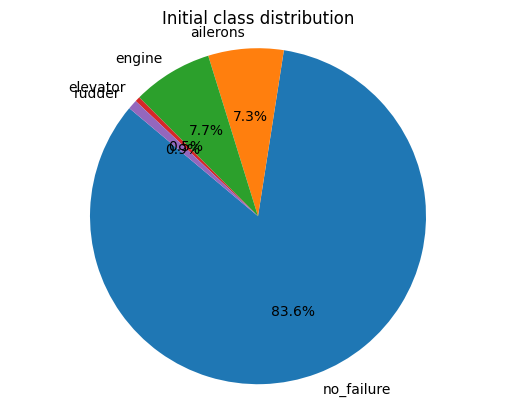

Classes size with respect to TRAIN size:
	 ->no_failure: 6251 (83.65%)
	 ->ailerons: 542 (7.25%)
	 ->engine: 576 (7.71%)
	 ->elevator: 36 (0.48%)
	 ->rudder: 68 (0.91%)


In [ ]:
# Ok now run DWT_SMOT on all the minority classes... But how do we define minority ?
# Easy, with counter and percentages :)

# First lets plot a piechart:
from collections import Counter
import matplotlib.pyplot as plt

def plotPie(cDistribution, title):
  sizes, labels = [], []
  for item in cDistribution.items():
    labels.append(item[0])
    sizes.append(item[1])

  plt.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=140)
  plt.title(title)

  plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.show()

# Obviusly get the distribution of the on the train y (right Alberto?)
cDistrubution = Counter(y_train.tolist())
cDistribution = {classToString[item[0]]:item[1] for item in cDistrubution.items()}
plotPie(cDistribution, "Initial class distribution")

lenDataset = y_train.shape[0]

# Also print them for fun
print("Classes size with respect to TRAIN size:")
for item in cDistribution.items():
  print(f"\t ->{item[0]}: {item[1]} ({float((item[1]/lenDataset)*100):.2f}%)")

# Get the distributions percentages to decide whether to use DWT_SMOTE or not
distribution = {stringToClass[item[0]]: item[1]/lenDataset for item in cDistribution.items()}


In [ ]:
# Connect to google drive so we can save the new windows in a csv for each class
import os
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p "/content/drive/My Drive/smoted_data"

Mounted at /content/drive


In [ ]:
import os
import numpy as np

# Run DWT_SMOTE for all the classes that are considered a minority
minorityThreshold = 0.25
undersamplePercentage = 0.75
max_index = int(np.max(X_train.index.get_level_values('flight').to_numpy()))+1

dir = "/content/drive/My Drive/smoted_data"
new_X_train, new_y_train = None, []
n_classes = len(classToString)

# I don't know a good way to tune them
_N = {"no_failure": 0, "elevator": 800, "engine": 200, "rudder": 600, "ailerons": 200}
_k = {"no_failure": 0, "elevator": 6, "engine": 4, "rudder": 6, "ailerons": 4}

for item in distribution.items():
  indexes = [i for i, c in enumerate(y_train.tolist()) if c ==item[0]]
  N = _N[classToString[item[0]]]
  k = _k[classToString[item[0]]]

  if item[1]> minorityThreshold:
    print(f"->UNDERSAMPLING '{classToString[item[0]]}'")

    # Multiplier to make the the quantity of the oversampled
    # class equal to the ((1/n_classes)*100)% of the train dataset
    nSamples = int(cDistribution[classToString[item[0]]]*undersamplePercentage)

    # NB: we should add Tomek-links removal first, like in SMOTEN,
    # before randomly sampling to the desired percentage ...

    # Undersample the huge class :_)
    new_indexes = np.random.choice(a=indexes, size=nSamples, replace=False) # With no repetition !
    fX = X_train[X_train.index.get_level_values('flight').isin(new_indexes)]

    # Save the values as a csv
    fX.to_csv(os.path.join(dir, f"{item[0]}.csv"))

    # Save the new Dataframe and labels

    new_X_train = pd.concat([new_X_train, fX])
    new_y_train += [item[0] for _ in range(nSamples)]

  else:
    print(f"->DTW_SMOTE '{classToString[item[0]]}' N={N} k={k}")
    # SMOTE PARAMS:
    T =  pd.DataFrame(X_train[X_train.index.get_level_values('flight').isin(indexes)])

    # Run DTW_SMOTE
    sampler = DTW_SMOTE(T, N, k, start = max_index)
    fX, fy= sampler.run(item[0])

    # Save the values as a CSV
    fX.to_csv(os.path.join(dir, f"{item[0]}.csv"))

    # Save the values for X, y and the flight index counter
    new_X_train = pd.concat([new_X_train, fX])
    new_y_train += fy
    max_index += len(fy) +1


  print(f"\t-new_X_train length: {np.unique(new_X_train.index.get_level_values('flight').to_numpy()).shape[0]}")
  print(f"\t-new_y_train length: {len(new_y_train)}")
  assert np.unique(new_X_train.index.get_level_values('flight').to_numpy()).shape[0] == len(new_y_train), f"{classToString[item[0]]} not the same lenght"


->UNDERSAMPLING 'no_failure'
	-new_X_train length: 4688
	-new_y_train length: 4688
->DTW_SMOTE 'ailerons' N=200 k=4
	-new_X_train length: 6314
	-new_y_train length: 6314
->DTW_SMOTE 'engine' N=200 k=4
	-new_X_train length: 8042
	-new_y_train length: 8042
->DTW_SMOTE 'elevator' N=800 k=6
	-new_X_train length: 8366
	-new_y_train length: 8366
->DTW_SMOTE 'rudder' N=600 k=6
	-new_X_train length: 8842
	-new_y_train length: 8842


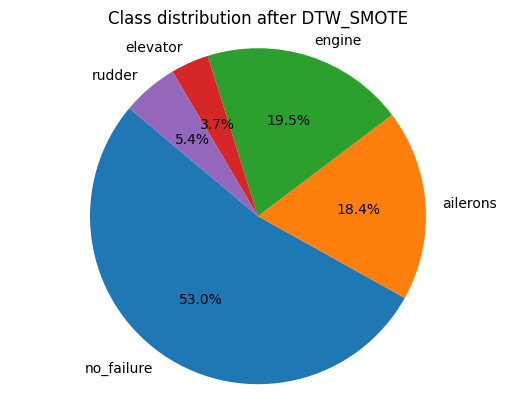

In [ ]:
# Resave the values as nothing happened ( The new inputs )
X_train = new_X_train
y_train = np.array(new_y_train)

# Final class distribution
cDistrubution = Counter(y_train.tolist())
cDistribution = {classToString[item[0]]:item[1] for item in cDistrubution.items()}
plotPie(cDistribution, "Class distribution after DTW_SMOTE")

## Testing Models:

In [ ]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.datatypes import check_raise
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.transformations.panel.interpolate import TSInterpolator

#  Apply feature Masks to the inputs
X_train, X_test = X_train[feature_mask], X_test[feature_mask]

In [ ]:
print("CONVOLUTIONAL NEURAL NETWORK")
cnn = CNNClassifier(n_epochs=50, batch_size=4, kernel_size=7, avg_pool_size=1, n_conv_layers=3, loss='binary_crossentropy')
check_raise(X_train, mtype="pd-multiindex")
check_raise(y_train, mtype='np.ndarray')
cnn.fit(X_train, y_train)

y_pred_cnn = cnn.predict(X_test)

cnn_acc = accuracy_score(y_test, y_pred_cnn)
print(f"Accuracy: {cnn_acc:.2f}")

report = classification_report(y_test, y_pred_cnn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classToString.items)#display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#clf = Pipeline([
#    ("transform", TSInterpolator(50)),
#     ("concatenate", ColumnConcatenator()),
#     ("classify", TimeSeriesForestClassifier(n_estimators=100)),
#    ("transform", PaddingTransformer()),
#    ("classify", RandomIntervalClassifier(n_intervals=10)),
#])
#clf.fit(X_train, y_train)
#clf.score(X_test,y_test)

CONVOLUTIONAL NEURAL NETWORK


KeyboardInterrupt: 

RECURRENT NEURAL NETWORK
134/134 [==============================] - 0s 2ms/step
Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      2243
         1.0       0.00      0.00      0.00         7
         2.0       0.82      0.67      0.74       195
         3.0       0.81      0.54      0.65        24
         4.0       0.25      0.01      0.01       199

    accuracy                           0.88      2668
   macro avg       0.56      0.44      0.47      2668
weighted avg       0.83      0.88      0.85      2668



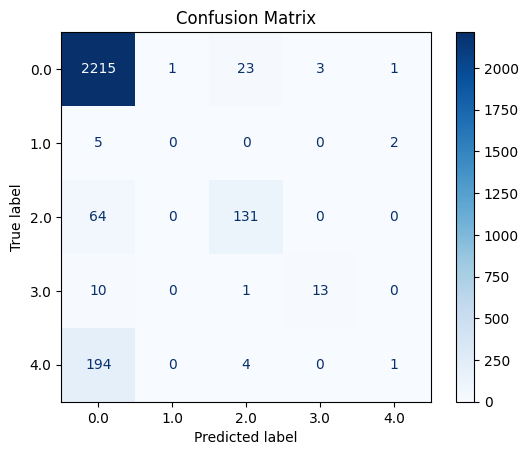

In [ ]:
from sktime.classification.deep_learning.rnn import SimpleRNNClassifier

print("RECURRENT NEURAL NETWORK")
rnn = SimpleRNNClassifier(n_epochs=50, batch_size=20, loss='binary_crossentropy')
rnn.fit(X_train, y_train)
# rnn.score(X_test, y_test)

y_pred_rnn = rnn.predict(X_test)

rnn_acc = accuracy_score(y_test, y_pred_rnn)
print(f"Accuracy: {rnn_acc:.2f}")

report = classification_report(y_test, y_pred_rnn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_rnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


K-NEIGHBORS
Accuracy della KNN: 0.86

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.90      0.92      1546
         1.0       0.50      0.80      0.62        10
         2.0       0.70      0.66      0.68       143
         3.0       0.53      0.64      0.58        14
         4.0       0.45      0.60      0.52       156

    accuracy                           0.86      1869
   macro avg       0.62      0.72      0.66      1869
weighted avg       0.87      0.86      0.86      1869



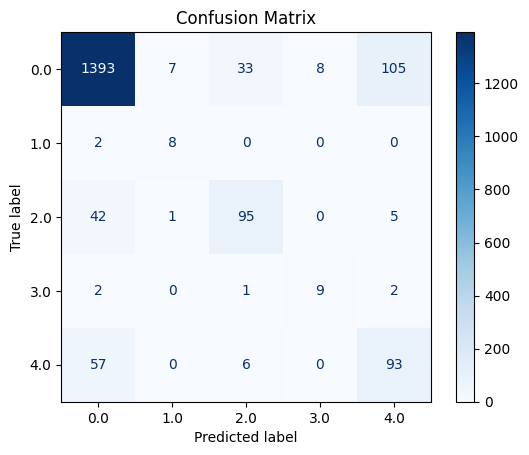

In [ ]:
print("K-NEIGHBORS")
knn = KNeighborsTimeSeriesClassifier(n_neighbors=5, distance='dtw')
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

knn_acc = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy della KNN: {knn_acc:.2f}")

report = classification_report(y_test, y_pred_knn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()